In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


## 底层实现版本

In [24]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [25]:
def synthetic_data(w,b,num_example):
  X = torch.normal(0,1,(num_example,len(w)))
  y = torch.matmul(X,w) + b
  y += torch.normal(0,0.01,y.shape)
  return X,y.reshape((-1,1)) #做成列向量返回

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

features中的每一行都包含一个二维数据样本,labels中的每一行都包含一维标签值（一个标量）

In [26]:
print('features:',features[0],'\nlabel',labels[0])

features: tensor([ 0.6472, -0.2518]) 
label tensor([6.3516])


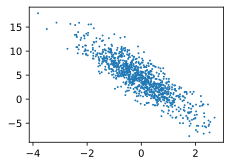

In [27]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

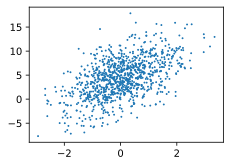

In [28]:
d2l.set_figsize()
d2l.plt.scatter(features[:,0].detach().numpy(),labels.detach().numpy(),1)

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [29]:
def data_iter(batch_size,features,labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  #这些样本是随机读取的，没有特定的顺序
  random.shuffle(indices) #把下标完全打乱
  for i in range(0,num_examples,batch_size):
    batch_indices = torch.tensor(
        indices[i:min(i+batch_size,num_examples)]
    )
    yield features[batch_indices],labels[batch_indices]

batch_size = 10

for X,y in data_iter(batch_size,features,labels):
  print(X,'\n',y)
  break

tensor([[ 1.0497,  0.4666],
        [-0.5147,  0.1821],
        [-0.4099,  1.9712],
        [-1.4596, -0.6591],
        [-0.4872,  0.2187],
        [ 1.9836, -0.7263],
        [ 0.3914, -0.1267],
        [-0.5591,  0.4562],
        [ 2.2887, -1.7566],
        [ 0.5913,  1.3766]]) 
 tensor([[ 4.7204],
        [ 2.5492],
        [-3.3267],
        [ 3.5103],
        [ 2.4821],
        [10.6402],
        [ 5.4230],
        [ 1.5239],
        [14.7529],
        [ 0.6933]])


初始化模型参数并定义模型

In [31]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [32]:
def linreg(X,w,b):
  return torch.matmul(X,w)+b

In [33]:
def squared_loss(y_hat,y):
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [35]:
def sgd(params,lr,batch_size):
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [36]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X,y in data_iter(batch_size,features,labels):
    l = loss(net(X,w,b),y) #X和y的小批量损失
    #因为l形状是(batch_size,1)，而不是一个标量。
    l.sum().backward()
    sgd([w,b],lr,batch_size)
  with torch.no_grad():
    train_l = loss(net(features,w,b),labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025007
epoch 2, loss 0.000092
epoch 3, loss 0.000051


比较真实参数和通过训练得到的参数来评估模型的成功程度

In [37]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b -b}')

w的估计误差: tensor([-8.4162e-05,  1.4257e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


## 框架实现版本

In [3]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [4]:
def load_array(data_arrays,batch_size,is_train=True):
  #构建一个pytorch数据迭代器
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size = 10
data_iter = load_array((features,labels),batch_size)

next(iter(data_iter))

[tensor([[-2.0440,  1.4126],
         [-0.3611,  0.0787],
         [ 0.5639, -0.2061],
         [ 2.0672,  0.7963],
         [ 0.6945, -1.2200],
         [-1.0452,  1.4303],
         [ 0.4150, -0.2665],
         [-0.5670, -0.3430],
         [ 0.3553,  1.4606],
         [ 0.3124,  0.9596]]), tensor([[-4.6829],
         [ 3.2050],
         [ 6.0217],
         [ 5.6397],
         [ 9.7339],
         [-2.7518],
         [ 5.9324],
         [ 4.2257],
         [-0.0538],
         [ 1.5717]])]

In [5]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

In [7]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [8]:
loss = nn.MSELoss()

In [9]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
  for X,y in data_iter:
    l = loss(net(X),y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features),labels)
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000102
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [ ]:
|